### Basic Imports

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import seaborn as sns
import pandas as pd

dist =torch.distributions

sns.reset_defaults()
sns.set_context(context="talk", font_scale=1)
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [64]:
from astra.torch.data import load_cifar_10
from astra.torch.utils import train_fn

In [65]:
# Create a sine activation class similar to ReLU
class Sine(nn.Module):
    def __init__(self):
        super().__init__()
        self.w = nn.Parameter(torch.tensor(1.0))
        self.b = nn.Parameter(torch.tensor(0.0))
        
    def forward(self, x):
        return torch.sin(self.w * x + self.b)

In [66]:
### Vanilla Autoencoder 

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(32 * 32 * 3, 128),
            Sine(),
            nn.Linear(128, 64),
            Sine(),
            nn.Linear(64, 32),
            Sine()
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            Sine(),
            nn.Linear(64, 128),
            Sine(),
            nn.Linear(128, 32 * 32 * 3),
            nn.Sigmoid()  # Sigmoid activation for pixel values between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [67]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [68]:
dataset = load_cifar_10()
dataset

Files already downloaded and verified
Files already downloaded and verified



CIFAR-10 Dataset
length of dataset: 60000
shape of images: torch.Size([3, 32, 32])
len of classes: 10
classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
dtype of images: torch.float32
dtype of labels: torch.int64
            

In [69]:
# Train over 1000 images
train_idx = torch.arange(1000)

X = dataset.data[train_idx].to(device)


model = Autoencoder().to(device)

In [70]:
model(X.view(-1, 32 * 32 * 3)).shape

torch.Size([1000, 3072])

In [71]:
# Get reconstruction
def get_reconstruction(model, X, model_type='MLP'):
    with torch.no_grad():
        model.eval()
        if model_type == 'MLP':
           X = X.view(-1, 32 * 32 * 3)
        X_hat = model(X)
        if model_type == 'MLP':
           X_hat = X_hat.view(-1, 3, 32, 32)
        return X_hat

In [72]:
get_reconstruction(model, X).shape

torch.Size([1000, 3, 32, 32])

In [73]:
# Plot original and reconstructed images
def plot_reconstructions(model, X, n=5, model_type='MLP'):
    X = X[:n]
    X_hat = get_reconstruction(model, X, model_type=model_type)
    X = X.cpu().numpy().transpose(0, 2, 3, 1)
    X_hat = X_hat.cpu().numpy().transpose(0, 2, 3, 1)
    fig, axes = plt.subplots(n, 2, figsize=(10, 10))
    for i in range(n):
        axes[i, 0].imshow(X[i])
        axes[i, 1].imshow(X_hat[i])
    # Remove xticks and yticks
    for ax in axes.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()

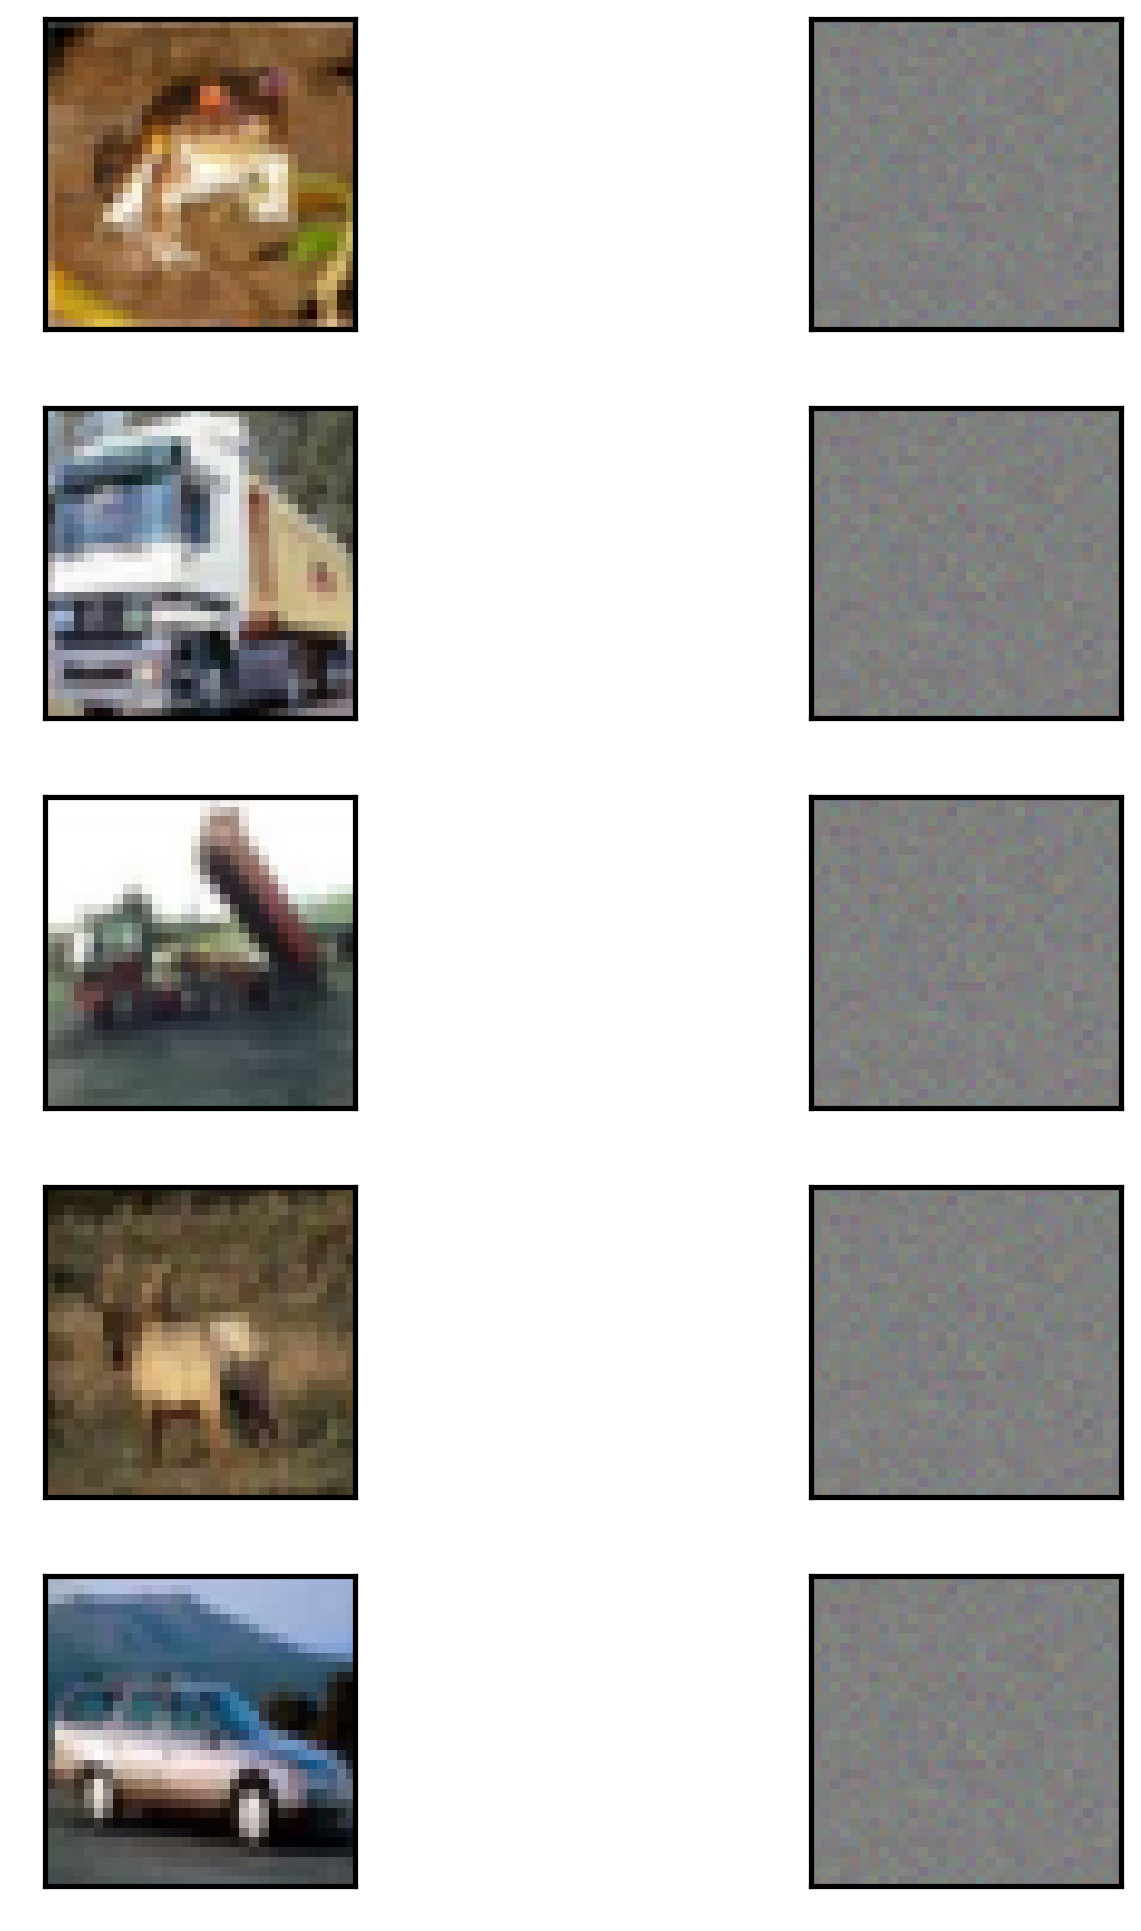

In [74]:
plot_reconstructions(model, X)

In [75]:
setattr(model, 'device', device)
iter_losses, epoch_losses = train_fn(model, X.view(-1, 32 * 32 * 3), X.view(-1, 32 * 32 * 3), nn.MSELoss(), lr=3e-4, 
                                     batch_size=128, epochs=400, verbose=False)


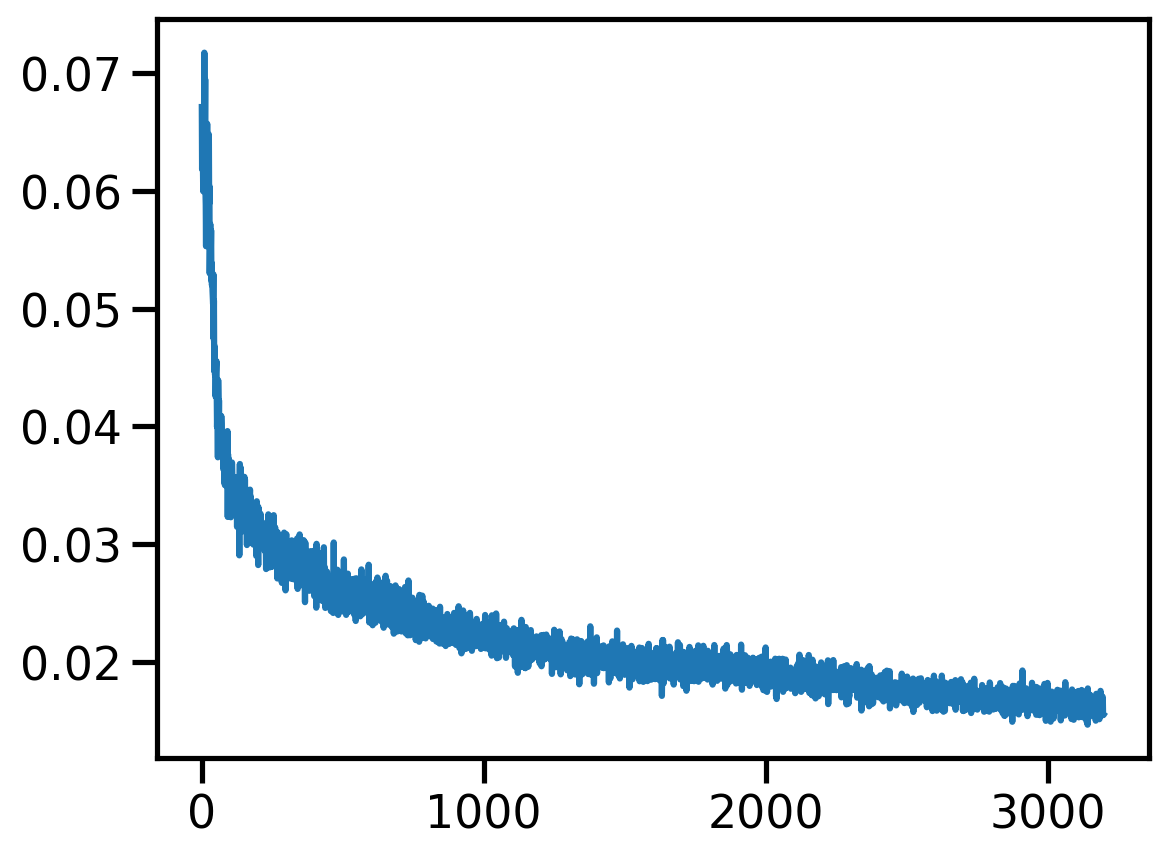

In [76]:
plt.plot(iter_losses)

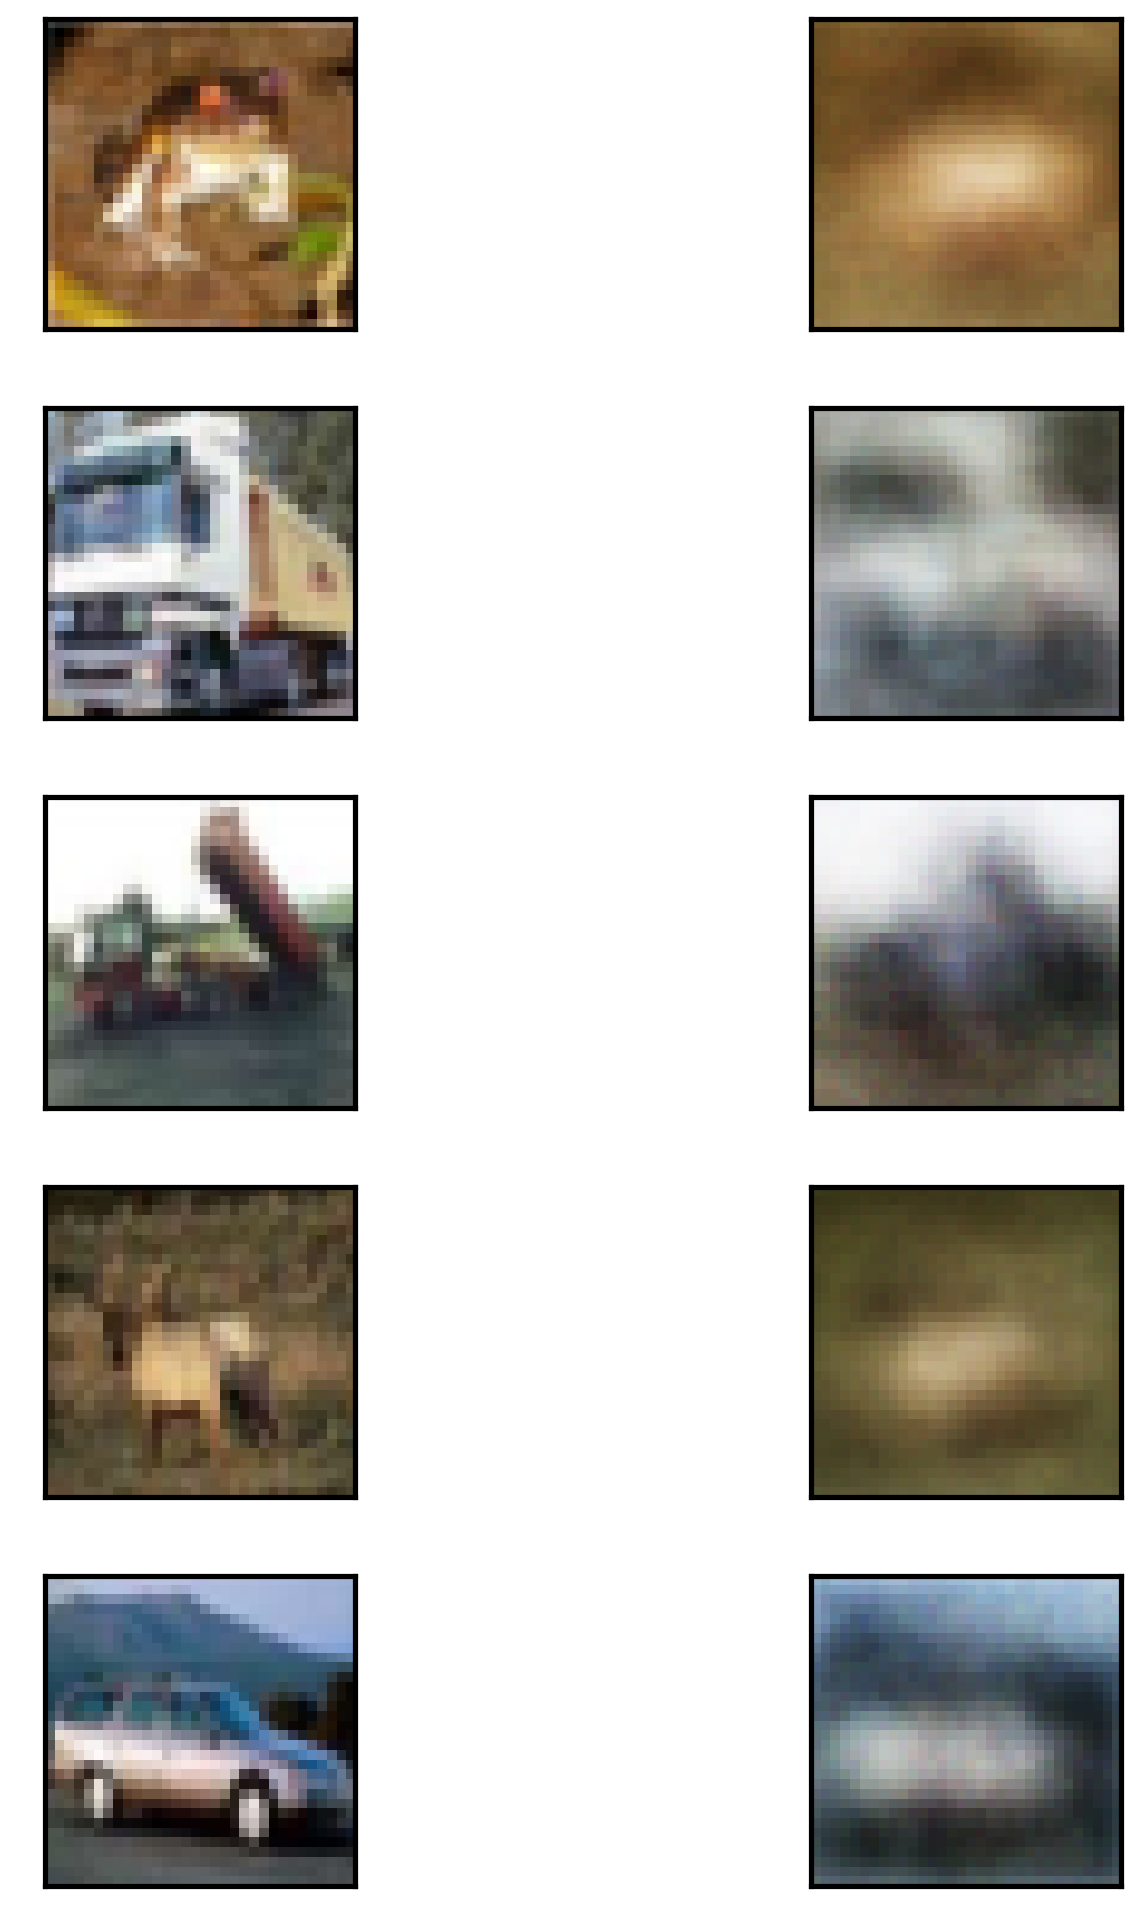

In [78]:
plot_reconstructions(model, X)

In [79]:
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super(ConvAutoEncoder, self).__init__()
        
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1), # input: 3 x 32 x 32, output: 16 x 16 x 16
            Sine(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # input: 16 x 16 x 16, output: 32 x 8 x 8
            Sine(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # input: 32 x 8 x 8, output: 64 x 4 x 4
            Sine()
        )
        
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1), # input: 64 x 4 x 4, output: 32 x 8 x 8
            Sine(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1), # input: 32 x 8 x 8, output: 16 x 16 x 16
            Sine(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1), # input: 16 x 16 x 16, output: 3 x 32 x 32
            nn.Sigmoid() # Sigmoid activation for pixel values between 0 and 1
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
                    

In [80]:
cae = ConvAutoEncoder().to(device)
setattr(cae, 'device', device)

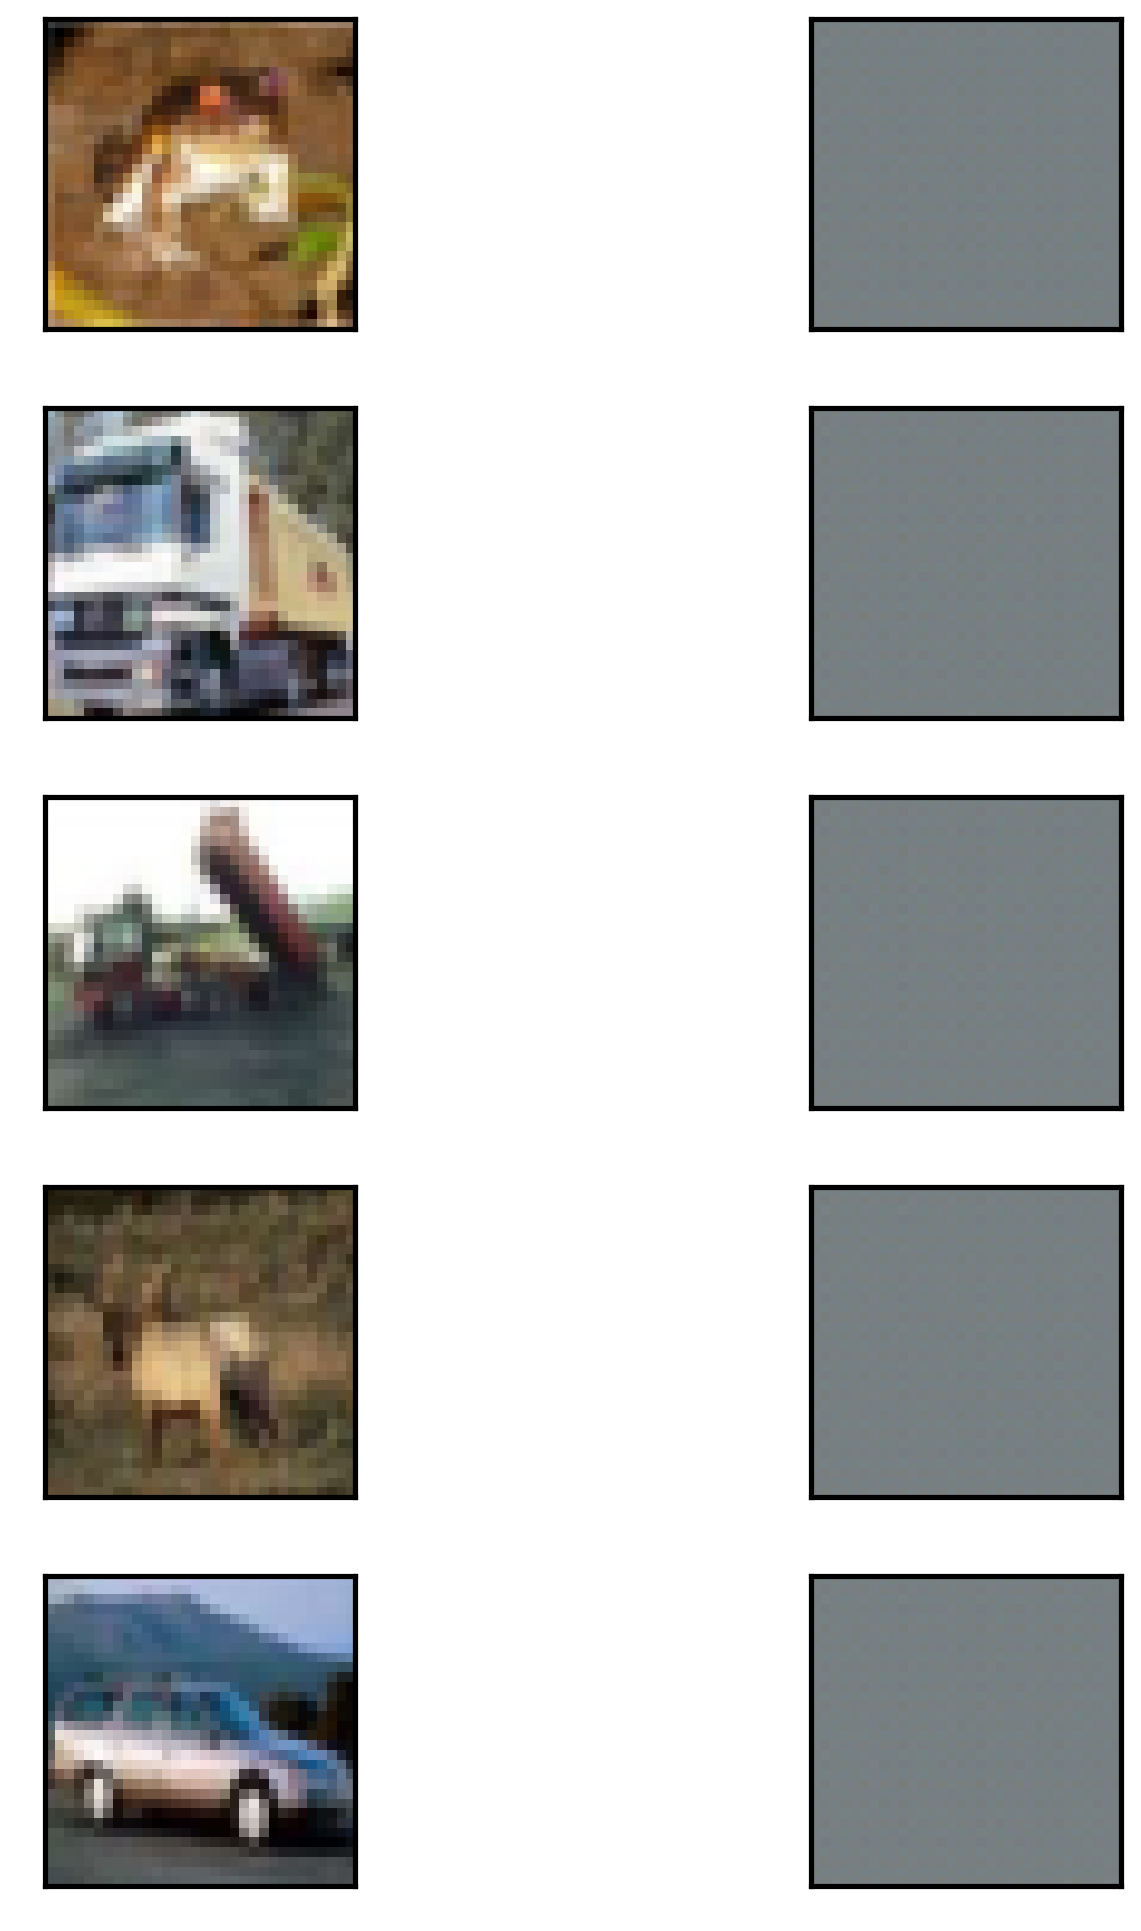

In [81]:
plot_reconstructions(cae, X, 5, model_type='CNN')

In [82]:
iter_losses, epoch_losses = train_fn(cae, X, X, nn.MSELoss(), lr=3e-4, 
                                     batch_size=128, epochs=400, verbose=False)


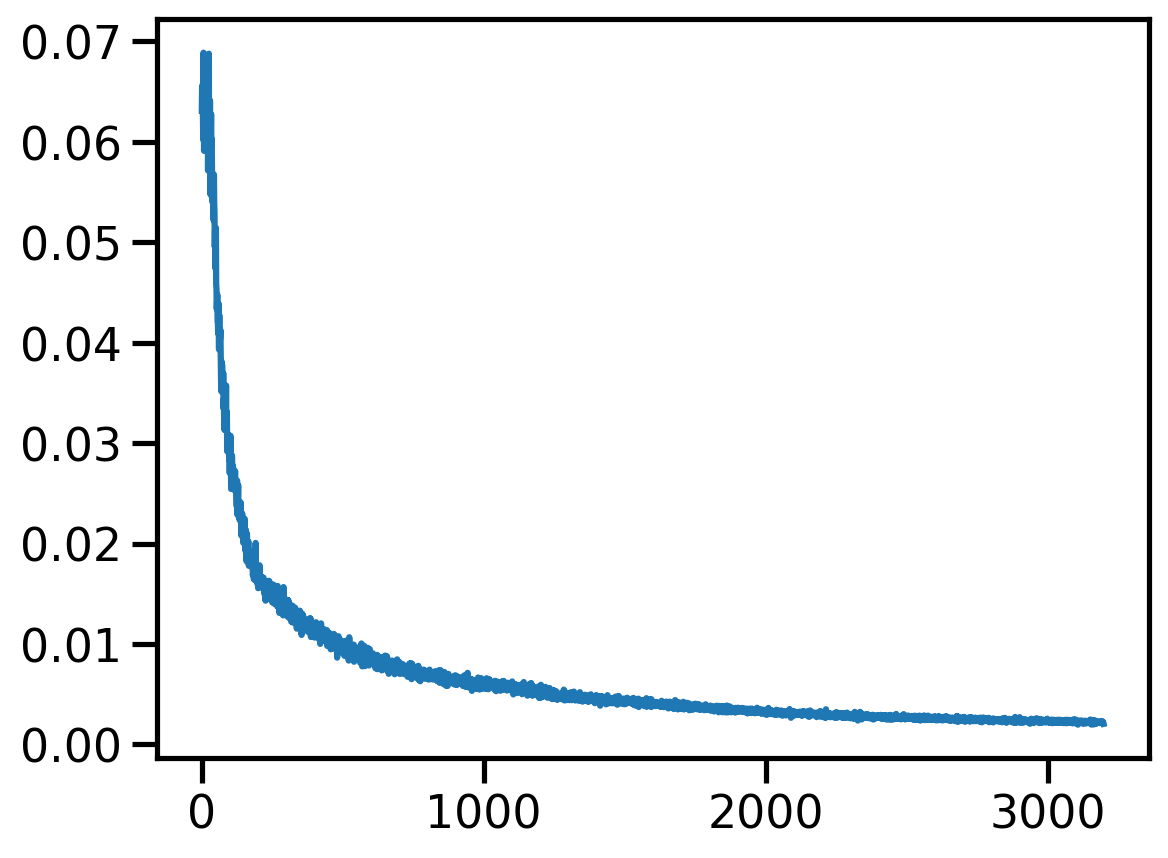

In [83]:
plt.plot(iter_losses)

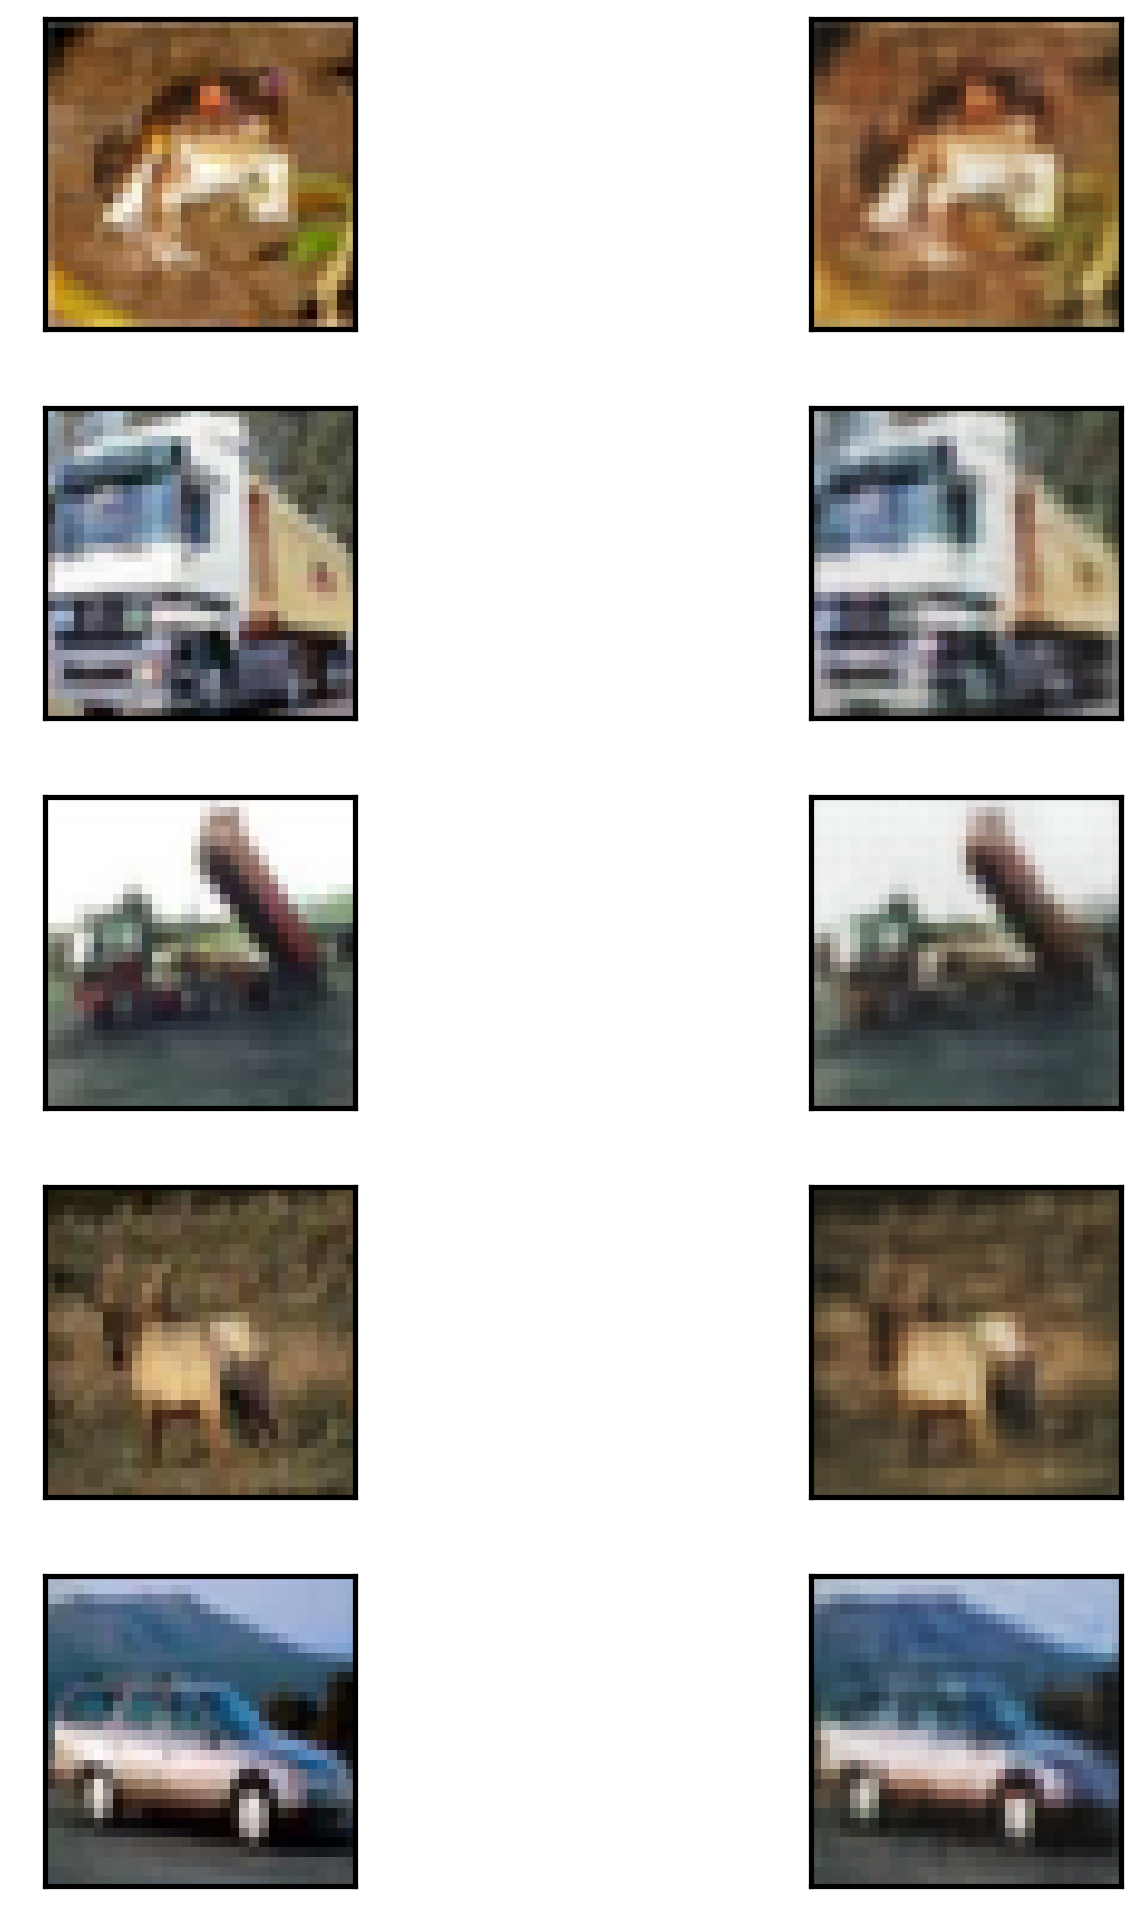

In [84]:
# Plot reconstructions
plot_reconstructions(cae, X, 5, 'CNN')